In [43]:
# Interaction Model v2 (GRU + Offseason Features, Cross-Attention)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, log_loss
import matplotlib.pyplot as plt

In [44]:
# ---------------------------
# Load Data
# ---------------------------
df = pd.read_csv("crossattn_gru_offseason_embeddings.csv")

# Label: 1 if Away team wins, else 0
y_all = (df["winner"] == df["away_team"]).astype(int).values

# Feature split
away_cols = [c for c in df.columns if c.startswith("A_")]
home_cols = [c for c in df.columns if c.startswith("B_")]

X_away = df[away_cols].values
X_home = df[home_cols].values

# Interaction features
diff = np.abs(X_away - X_home)
prod = X_away * X_home
cos_sim = np.sum(X_away * X_home, axis=1) / (
    np.linalg.norm(X_away, axis=1) * np.linalg.norm(X_home, axis=1) + 1e-8
)
cos_sim = cos_sim.reshape(-1, 1)

# Final feature set
X_all = np.hstack([X_away, X_home, diff, prod, cos_sim])
weeks = df["week"].unique()
weeks.sort()

print("Data shape:", X_all.shape, "Labels:", y_all.shape)

Data shape: (272, 129) Labels: (272,)


In [52]:
# ---------------------------
# Interaction Model
# ---------------------------
def build_interaction_model(input_dim):
    inp = Input(shape=(input_dim,))
    
    x = layers.Dense(256, activation="relu")(inp)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    out = layers.Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [74]:
import warnings
warnings.filterwarnings('ignore')
# ---------------------------
# Walk-forward loop
# ---------------------------
results = []
warm_model = None

for i in range(1, len(weeks)):
    wk = weeks[i]
    prev_wks = weeks[:i]

    train_idx = df['week'].isin(prev_wks)
    test_idx  = df['week'] == wk

    X_train, y_train = X_all[train_idx], y_all[train_idx]
    X_test, y_test   = X_all[test_idx],  y_all[test_idx]

    print(f"Training weeks: {prev_wks[0]} → {prev_wks[-1]}, "
          f"Testing week: {wk}, "
          f"n_train={len(y_train)}, n_test={len(y_test)}")

    if len(y_test) == 0:  # skip if no test games
        continue

    # --- Warm start ---
    if warm_model is None:
        warm_model = build_interaction_model(X_all.shape[1])
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
        warm_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    # callbacks
    lr_sched = ReduceLROnPlateau(monitor="val_loss", factor=0.75, patience=25, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True, verbose=1)

    history = warm_model.fit(
        X_train, y_train,
        validation_split=0.1,
        shuffle=False,
        epochs=500,
        batch_size=min(32, max(4, len(X_train)//4)),
        verbose=0,
        callbacks=[lr_sched, early_stop]
    )

    # evaluate
    y_pred_prob = warm_model.predict(X_test, verbose=0).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    ll  = log_loss(y_test, y_pred_prob, labels=[0,1])

    results.append({
        "week": wk,
        "n_games": len(y_test),
        "accuracy": acc,
        "log_loss": ll,
        "epochs_run": len(history.history['loss'])
    })

results_df = pd.DataFrame(results)
print(results_df)

Training weeks: 202401 → 202401, Testing week: 202402, n_train=16, n_test=16
Restoring model weights from the end of the best epoch: 500.
Training weeks: 202401 → 202402, Testing week: 202403, n_train=32, n_test=16

Epoch 39: ReduceLROnPlateau reducing learning rate to 7.499999810534064e-06.

Epoch 106: ReduceLROnPlateau reducing learning rate to 5.624999857900548e-06.
Epoch 125: early stopping
Restoring model weights from the end of the best epoch: 100.
Training weeks: 202401 → 202403, Testing week: 202404, n_train=48, n_test=16
Restoring model weights from the end of the best epoch: 500.
Training weeks: 202401 → 202404, Testing week: 202405, n_train=64, n_test=14

Epoch 103: ReduceLROnPlateau reducing learning rate to 4.2187500639556674e-06.
Restoring model weights from the end of the best epoch: 500.
Training weeks: 202401 → 202405, Testing week: 202406, n_train=78, n_test=14

Epoch 26: ReduceLROnPlateau reducing learning rate to 3.164062718497007e-06.
Epoch 27: early stopping
Resto

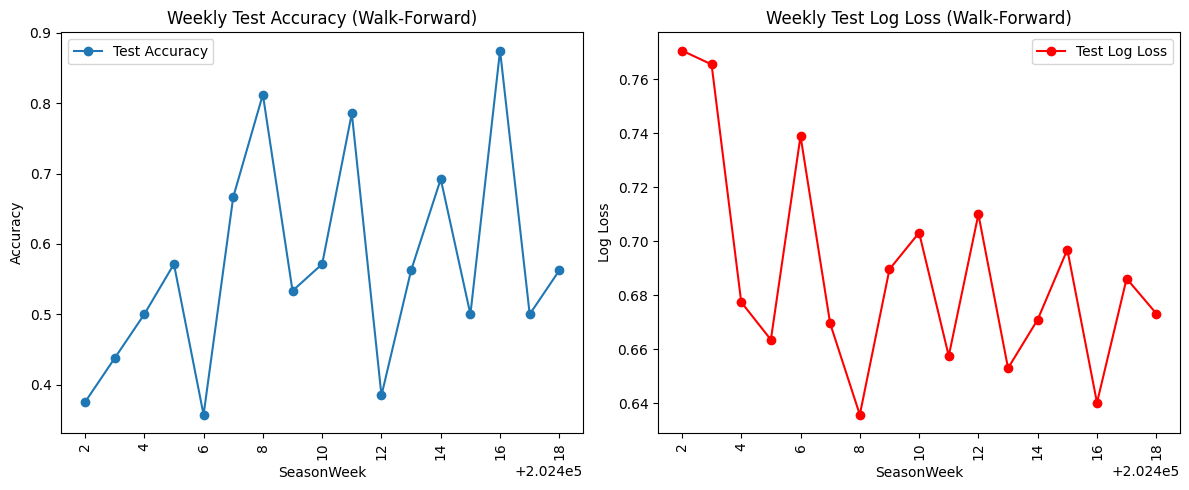

In [75]:
# ---------------------------
# Visualization
# ---------------------------
plt.figure(figsize=(12,5))

# Accuracy per week
plt.subplot(1,2,1)
plt.plot(results_df["week"], results_df["accuracy"], marker="o", label="Test Accuracy")
plt.xlabel("SeasonWeek")
plt.ylabel("Accuracy")
plt.title("Weekly Test Accuracy (Walk-Forward)")
plt.xticks(rotation=90)
plt.legend()

# Log loss per week
plt.subplot(1,2,2)
plt.plot(results_df["week"], results_df["log_loss"], marker="o", color="red", label="Test Log Loss")
plt.xlabel("SeasonWeek")
plt.ylabel("Log Loss")
plt.title("Weekly Test Log Loss (Walk-Forward)")
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

In [77]:
warm_model.save("XAtt_interaction_model.keras")